In [57]:
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd 
from sklearn.model_selection import train_test_split
from keras.layers.core import Dense, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from scipy.interpolate import interp1d
from datetime import date, timedelta
from sklearn.preprocessing import MinMaxScaler
from dateutil.relativedelta import relativedelta

In [58]:
from mny import money

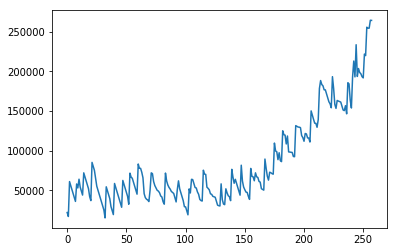

In [59]:
balance = [k for k,_ in money]
balance = np.cumsum(balance)
plt.plot(balance)

In [60]:
dates = []
for _,k in money:
    dates.append(date(k//10000, (k//100)%100 ,k%100))


In [61]:
df = pd.DataFrame(balance, index=dates, columns = ['Balance'])

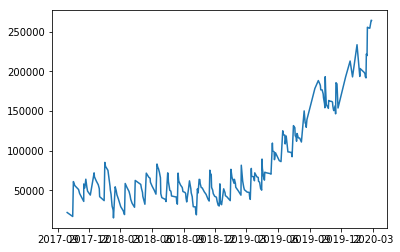

In [62]:
plt.plot(df['Balance'])

In [63]:
def convert_dates_to_days(dates, start_date=None):
    """Converts a series of dates to a series of float values that
    represent days since start_date.
    """
    sol = []
    for i in range(len(dates)):
        sol.append((dates[i]-dates[0]).days)
    return sol

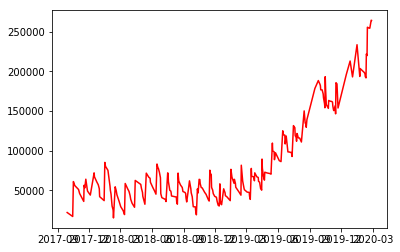

In [64]:
X = convert_dates_to_days(df.index)
y = balance
f2 = interp1d(X, y)

sdate = df.index[0]   # start date
edate = df.index[df.index.shape[0]-1]   # end date
delta = edate - sdate       # as timedelta

Pdates = []
Pbalance = []
for i in range(delta.days + 1):
    day = sdate + timedelta(days=i)
    Pdates.append(day)
    Pbalance.append(f2(i))

Pdf = pd.DataFrame(Pbalance, index=Pdates, columns=['Balance'])
plt.plot(Pdf['Balance'], 'r')

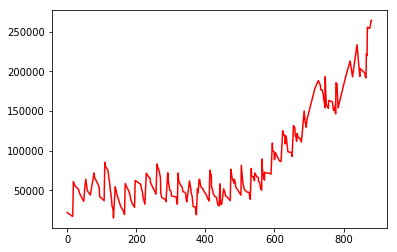

In [65]:
plt.plot(X,f2(X), 'r')

In [66]:
dataset = Pdf.values

In [67]:
training_data_len = math.ceil(len(dataset)*.8)
training_data_len

706

In [68]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(dataset)

In [69]:
train_data = scaled_data[0:training_data_len,:]
X_train = []
y_train = []

lastXdays = 91

for i in range(lastXdays, len(train_data)):
    X_train.append(train_data[i-lastXdays:i,0])
    y_train.append(train_data[i,0])

In [70]:
X_train, y_train = np.array(X_train), np.array(y_train)

In [71]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [72]:
model = Sequential()
model.add(LSTM(50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(LSTM(50, return_sequences = False))
model.add(Dense(25))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [83]:
model.fit(X_train, y_train, batch_size = 1, epochs = 10)

Epoch 1/10
615/615 [==============================] - 131s 213ms/step - loss: 0.0014
Epoch 2/10
615/615 [==============================] - 137s 223ms/step - loss: 9.8058e-04
Epoch 3/10
615/615 [==============================] - 138s 224ms/step - loss: 6.8829e-04
Epoch 4/10
615/615 [==============================] - 139s 226ms/step - loss: 5.9883e-04
Epoch 5/10
615/615 [==============================] - 142s 230ms/step - loss: 5.1993e-04
Epoch 6/10
615/615 [==============================] - 144s 234ms/step - loss: 5.4475e-04
Epoch 7/10
615/615 [==============================] - 143s 233ms/step - loss: 5.5276e-04
Epoch 8/10
615/615 [==============================] - 146s 237ms/step - loss: 5.8452e-04
Epoch 9/10
615/615 [==============================] - 144s 234ms/step - loss: 5.2776e-04
Epoch 10/10
615/615 [==============================] - 145s 235ms/step - loss: 6.1548e-04


In [84]:
test_data = scaled_data[training_data_len-lastXdays:,:]
X_test = []
y_test = dataset[training_data_len:,:]

for i in range(lastXdays, len(test_data)):
    X_test.append(test_data[i-lastXdays:i,0])

In [85]:
X_test = np.array(X_test)

In [86]:
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [87]:
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

In [88]:
rmse =np.sqrt(np.mean(((predictions- y_test)**2)))
rmse

6566.316542096377

c:\users\rade\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


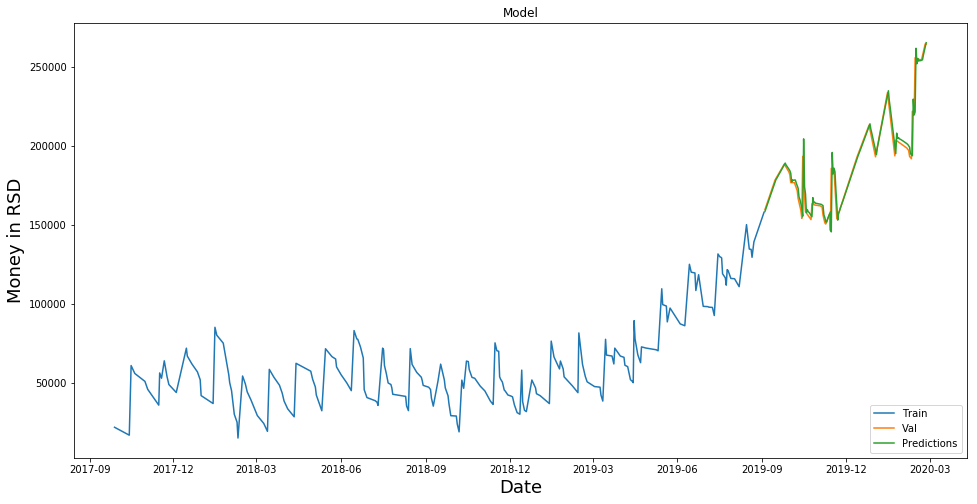

In [89]:
train = Pdf[:training_data_len]
valid = Pdf[training_data_len:]
valid['Predictions'] = predictions

plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Money in RSD', fontsize=18)
plt.plot(train['Balance'])
plt.plot(valid[['Balance','Predictions']])
plt.legend(['Train','Val','Predictions'], loc='lower right')
plt.show()

In [90]:
predict_next = Pdf[-lastXdays:].values
predict_next_scaled = scaler.transform(predict_next)
X_test = []
X_test.append(predict_next_scaled)
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
pred_price = model.predict(X_test)
pred_price = scaler.inverse_transform(pred_price)
pred_price

array([[264738.06]], dtype=float32)

In [91]:
sdate = df.index[df.index.shape[0]-1]+ timedelta(days=1)   # start date
edate = df.index[df.index.shape[0]-1]+ relativedelta(years=1)  # end date
delta = edate - sdate       # as timedelta

predict_next = Pdf[-lastXdays:].values
Ndates = Pdf.index[-lastXdays:]
for i in range(delta.days+ 1):
    Nbalance = []
    day = sdate + timedelta(days=i)
    Ndates = np.concatenate((Ndates,pd.Index([day])))
    predict_next2 = predict_next[-lastXdays:]
    predict_next_scaled = scaler.transform(predict_next2)
    X_test = []
    X_test.append(predict_next_scaled)
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    pred_price = model.predict(X_test)
    pred_price = scaler.inverse_transform(pred_price)
    predict_next = np.concatenate((predict_next, np.matrix(pred_price[0])))

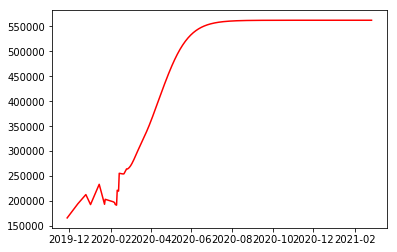

In [92]:
Ndf = pd.DataFrame(predict_next, index=Ndates, columns=['Balance'])
plt.plot(Ndf['Balance'], 'r')